# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore') 

# Hyperparameter setting

In [2]:
CFG = {
    'EPOCHS': 30,
    'LEARNING_RATE':1e-2,
    'BATCH_SIZE':256,
    'SEED':41
}

# Data Load

In [3]:
train = pd.read_csv('./data/open/train.csv')
test = pd.read_csv('./data/open/test.csv')

# Data Preprocessing
1. 결측치 처리
2. Train / Validation 분할
3. Data label-encoding, scaling

In [4]:
categorical_features = ['COMPONENT_ARBITRARY', 'YEAR']
# Inference(실제 진단 환경)에 사용하는 컬럼
test_stage_features = ['COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR' , 'ANONYMOUS_2', 'AG', 'CO', 'CR', 'CU', 'FE',
                       'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN']

In [5]:
train = train.fillna(0)
test = test.fillna(0)

<AxesSubplot:>

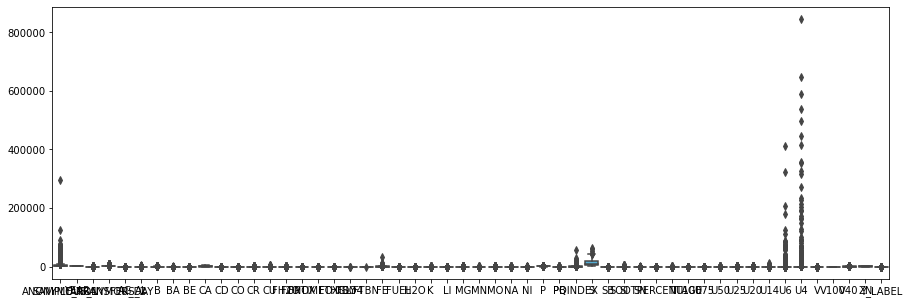

In [6]:
# train.describe()
plt.figure(figsize=(15,5))
sns.boxplot(data = train)

In [7]:
test.head()

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN
0,TEST_0000,COMPONENT1,2192,2016,200,0,0,0,1,12,0.0,0,0,0,10,0,0,91.3,1091
1,TEST_0001,COMPONENT3,2794,2011,200,0,0,2,1,278,0.0,3,0,0,2732,1,0,126.9,12
2,TEST_0002,COMPONENT2,1982,2010,200,0,0,0,16,5,0.0,0,0,0,11,0,0,44.3,714
3,TEST_0003,COMPONENT3,1404,2009,200,0,0,3,4,163,0.0,4,3,0,8007,0,0,142.8,94
4,TEST_0004,COMPONENT2,8225,2013,200,0,0,0,6,13,0.0,0,0,0,16,0,0,63.4,469


In [8]:
from sklearn.model_selection import train_test_split
all_x = train.drop(['ID', 'Y_LABEL'], axis = 1)
all_y = train['Y_LABEL']

test = test.drop(['ID'], axis = 1)

train_x, val_x, train_y, val_y = train_test_split(all_x, all_y, test_size=0.2, random_state=CFG['SEED'], stratify=all_y)

In [9]:
train_x.shape , val_x.shape, train_y.shape, val_y.shape

((11276, 52), (2819, 52), (11276,), (2819,))

In [10]:
from sklearn.preprocessing import RobustScaler, LabelEncoder

def get_values(value):
    return value.values.reshape(-1, 1)

for col in train_x.columns:
    if col not in categorical_features:
        scaler = RobustScaler()
        train_x[col] = scaler.fit_transform(get_values(train_x[col]))
        val_x[col] = scaler.transform(get_values(val_x[col]))
        if col in test.columns:
            test[col] = scaler.transform(get_values(test[col]))
            
le = LabelEncoder()
for col in categorical_features:    
    train_x[col] = le.fit_transform(train_x[col])
    val_x[col] = le.transform(val_x[col])
    if col in test.columns:
        test[col] = le.transform(test[col])

In [11]:
test.head()

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN
0,0,-0.014439,9,0.0,0.0,0.0,-0.333333,-0.1875,-0.232,0.0,-0.5,-0.142857,0.0,-0.105882,0.0,0.0,-0.305215,0.527290
1,2,0.265952,4,0.0,0.0,0.0,0.333333,-0.1875,1.896,0.0,1.0,-0.142857,0.0,15.905882,1.0,0.0,0.240798,-0.470860
2,1,-0.112250,3,0.0,0.0,0.0,-0.333333,0.7500,-0.288,0.0,-0.5,-0.142857,0.0,-0.100000,0.0,0.0,-1.026074,0.178538
3,2,-0.381463,2,0.0,0.0,0.0,0.666667,0.0000,0.976,0.0,1.5,0.285714,0.0,46.935294,0.0,0.0,0.484663,-0.395005
4,1,2.795529,6,0.0,0.0,0.0,-0.333333,0.1250,-0.224,0.0,-0.5,-0.142857,0.0,-0.070588,0.0,0.0,-0.733129,-0.048104


#  지식증류(Knowledge Distillation)

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras

In [13]:
# 교사 모델 생성
teacher = keras.Sequential([
    keras.Input(shape=(52,)),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dense(1024),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dense(1),
    layers.BatchNormalization(),
    layers.Activation(activation='sigmoid')],
    name = 'teacher')

In [14]:
# 학생 모델 생성
student = keras.Sequential([
    keras.Input(shape=(18,)),
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dense(512),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dense(1),
    layers.BatchNormalization(),
    layers.Activation(activation='sigmoid')],
    name = 'student')

In [15]:
# # 교사모델 훈련
# teacher.compile(
#     optimizer=keras.optimizers.Adam()
#     ,loss = keras.losses.binary_crossentropy
#     ,metrics=['accuracy']
# )
# callback = [
#     keras.callbacks.EarlyStopping(patience = 7),
#     keras.callbacks.ModelCheckpoint('teacher.model.keras',save_best_only=True)
# ]
# teacher.fit(train_x,train_y, epochs=100, callbacks=callback, validation_data=(val_x,val_y))
# teacher_loadmodel = keras.models.load_model('teacher.model.keras')
# teacher_loadmodel.evaluate(val_x,val_y)

In [16]:
student_train_x =   train_x.loc[:,test_stage_features]
student_val_x = val_x.loc[:,test_stage_features]
student_train_x.shape, train_y.shape, student_val_x.shape, val_y.shape

((11276, 18), (11276,), (2819, 18), (2819,))

In [17]:
# 학생모델 훈련
student.compile(
    optimizer=keras.optimizers.Adam()
    ,loss = keras.losses.binary_crossentropy
    ,metrics=['accuracy']
)
callback = [
    keras.callbacks.EarlyStopping(patience = 7),
    keras.callbacks.ModelCheckpoint('student.model.keras',save_best_only=True)
]
student.fit(student_train_x,train_y,epochs=100,callbacks=callback, validation_data=(student_val_x,val_y))
student_loadmodel = keras.models.load_model('student.model.keras')
student_loadmodel.evaluate(student_val_x,val_y)

Epoch 1/100
353/353 [==============================] - 2s 2ms/step - loss: 0.6829 - accuracy: 0.7011 - val_loss: 0.6099 - val_accuracy: 0.8663
Epoch 2/100
353/353 [==============================] - 1s 2ms/step - loss: 0.5386 - accuracy: 0.8186 - val_loss: 0.4837 - val_accuracy: 0.8943
Epoch 3/100
353/353 [==============================] - 1s 2ms/step - loss: 0.4465 - accuracy: 0.8882 - val_loss: 0.4291 - val_accuracy: 0.8996
Epoch 4/100
353/353 [==============================] - 1s 2ms/step - loss: 0.3898 - accuracy: 0.9101 - val_loss: 0.3749 - val_accuracy: 0.9092
Epoch 5/100
353/353 [==============================] - 1s 2ms/step - loss: 0.3531 - accuracy: 0.9130 - val_loss: 0.3431 - val_accuracy: 0.9124
Epoch 6/100
353/353 [==============================] - 1s 2ms/step - loss: 0.3284 - accuracy: 0.9145 - val_loss: 0.3212 - val_accuracy: 0.9131
Epoch 7/100
353/353 [==============================] - 1s 2ms/step - loss: 0.3108 - accuracy: 0.9147 - val_loss: 0.3114 - val_accuracy: 0.9120

[0.2816060185432434, 0.9141539335250854]

In [18]:
preds = student_loadmodel.predict(test)
preds

array([[0.06184819],
       [0.09532583],
       [0.10016528],
       ...,
       [0.10194567],
       [0.06289145],
       [0.05312639]], dtype=float32)

In [19]:
np.unique(np.round(preds),return_counts = True)

(array([0., 1.], dtype=float32), array([6031,   10], dtype=int64))

In [20]:
# submission1 파일 생성 및 제출
submit = pd.read_csv('./data/open/sample_submission.csv')
submit['Y_LABEL'] = np.round(preds)
submit.to_csv('./submit1.csv', index=False)

### PCA를 이용해서 차원을 숙초하여 차수를 맞춤

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 18)
pca_train_x = pca.fit_transform(train_x)
pca_val_x = pca.fit_transform(val_x)

In [22]:
pca_train_x.shape, pca_val_x.shape, test.shape

((11276, 18), (2819, 18), (6041, 18))

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [24]:
# 랜덤 포레스트 모델 생성
rf = RandomForestClassifier(n_estimators=10, random_state=2, n_jobs= -1)

In [25]:
# 교차 검증 수행
scores = cross_val_score(rf, pca_train_x, train_y, cv = 5)

In [26]:
print(f'정확도 : {np.round(scores,3)}')
print(f'정확도 평균: {np.mean(scores):.3f}')

정확도 : [0.951 0.951 0.953 0.953 0.949]
정확도 평균: 0.951


In [27]:
# 랜덤 포레스트
rf.fit(pca_train_x, train_y)
predict = rf.predict(pca_val_x)
print(f"정확도 : {accuracy_score(predict,val_y)}")
print(f"정밀도 : {precision_score(predict,val_y)}")
print(f"재현율 : {recall_score(predict,val_y)}")
print(f"F1_Score : {f1_score(predict,val_y)}")

정확도 : 0.8772614402270309
정밀도 : 0.36099585062240663
재현율 : 0.3118279569892473
F1_Score : 0.33461538461538465


In [28]:
# 의사결정 나무
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=3)
dtc.fit(pca_train_x,train_y)
predict = dtc.predict(pca_val_x)
print(f"정확도 : {accuracy_score(predict,val_y)}")
print(f"정밀도 : {precision_score(predict,val_y)}")
print(f"재현율 : {recall_score(predict,val_y)}")
print(f"F1_Score : {f1_score(predict,val_y)}")

정확도 : 0.8850656261085491
정밀도 : 0.34024896265560167
재현율 : 0.3319838056680162
F1_Score : 0.33606557377049184


In [29]:
# GBM
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(max_depth=2, n_estimators=3, random_state=2, learning_rate=1.0)
gbc.fit(pca_train_x,train_y)
predict = gbc.predict(pca_val_x)
print(f"정확도 : {accuracy_score(predict,val_y)}")
print(f"정밀도 : {precision_score(predict,val_y)}")
print(f"재현율 : {recall_score(predict,val_y)}")
print(f"F1_Score : {f1_score(predict,val_y)}")

정확도 : 0.8854203618304364
정밀도 : 0.34024896265560167
재현율 : 0.3333333333333333
F1_Score : 0.33675564681724846


In [30]:
# GBM 튜닝
from sklearn.model_selection import RandomizedSearchCV

params = {'subsample':[0.65,0.7,0.75],
         'n_estimators':[300,500,1000],
         'learning_rate':[0.05,0.075,0.1]}

rand_reg = RandomizedSearchCV(gbc,params,n_iter=10,
                              scoring='neg_mean_squared_error',
                              cv = 5, n_jobs= -1, random_state=2, verbose=2)

rand_reg.fit(pca_train_x,train_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=GradientBoostingClassifier(learning_rate=1.0,
                                                        max_depth=2,
                                                        n_estimators=3,
                                                        random_state=2),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.075, 0.1],
                                        'n_estimators': [300, 500, 1000],
                                        'subsample': [0.65, 0.7, 0.75]},
                   random_state=2, scoring='neg_mean_squared_error', verbose=2)

In [31]:
# rand_reg.best_estimator_
predict = rand_reg.best_estimator_.predict(pca_val_x)
print(f"정확도 : {accuracy_score(predict,val_y)}")
print(f"정밀도 : {precision_score(predict,val_y)}")
print(f"재현율 : {recall_score(predict,val_y)}")
print(f"F1_Score : {f1_score(predict,val_y)}")

정확도 : 0.884710890386662
정밀도 : 0.34439834024896265
재현율 : 0.332
F1_Score : 0.33808553971486766


In [32]:
# XGB
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

xgb = XGBClassifier()

# XGB튜닝
params = {'subsample':[0.65, 0.7, 0.75],
          'n_estimators':[100,200, 300, 400,800],
          'learning_rate':[0.01,0.05,0.1,0.2,0.3,0.4,0.5],
          'max_depth' : [2,3,5,6,8],
          'gamma' : [0,0.01,0.1,0.5,1,2]
         }
rand_reg = RandomizedSearchCV(xgb,params,n_iter=10,scoring='neg_mean_squared_error'
                              ,cv=5,n_jobs=-1,random_state=2,verbose=1)
rand_reg.fit(pca_train_x,train_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           monotone_constraints=None,
                         

In [33]:
predict = rand_reg.best_estimator_.predict(pca_val_x)
print(f"정확도 : {accuracy_score(predict,val_y)}")
print(f"정밀도 : {precision_score(predict,val_y)}")
print(f"재현율 : {recall_score(predict,val_y)}")
print(f"F1_Score : {f1_score(predict,val_y)}")

정확도 : 0.8857750975523235
정밀도 : 0.34024896265560167
재현율 : 0.3346938775510204
F1_Score : 0.3374485596707819


In [34]:
# XGB Booster
xgb = XGBClassifier(booster = 'gbtree', max_depth = 6, objective='binary:logistic',
                    learning_rate = 0.1, n_estimators = 100, n_jobs= -1)
xgb.fit(pca_train_x,train_y)
predict = xgb.predict(pca_val_x)
print(f"정확도 : {accuracy_score(predict,val_y)}")
print(f"정밀도 : {precision_score(predict,val_y)}")
print(f"재현율 : {recall_score(predict,val_y)}")
print(f"F1_Score : {f1_score(predict,val_y)}")

정확도 : 0.8832919474991131
정밀도 : 0.3070539419087137
재현율 : 0.3135593220338983
F1_Score : 0.310272536687631


In [35]:
pca = PCA(n_components=1)
pca_train_x =  pca.fit_transform(train_x)
pca_val_x = pca.fit_transform(val_x)
pca_test = pca.fit_transform(test)

xgb = XGBClassifier(booster = 'gbtree', max_depth = 6, objective='binary:logistic',
                    learning_rate = 0.1, n_estimators = 100, n_jobs= -1)

params = {'subsample':[0.65, 0.7, 0.75],
          'n_estimators':[100,200, 300, 400,800],
          'learning_rate':[0.01,0.05,0.1,0.2,0.3,0.4,0.5],
          'max_depth' : [2,3,5,6,8],
          'gamma' : [0,0.01,0.1,0.5,1,2]
         }

rand_reg = RandomizedSearchCV(xgb,params,n_iter=10,scoring='neg_mean_squared_error'
                              ,cv=5,n_jobs=-1,random_state=2,verbose=1)
rand_reg.fit(pca_train_x,train_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_...
                                           monotone_constraints=None,
                         

In [36]:
predict = rand_reg.best_estimator_.predict(pca_val_x)
print(f"정확도 : {accuracy_score(predict,val_y)}")
print(f"정밀도 : {precision_score(predict,val_y)}")
print(f"재현율 : {recall_score(predict,val_y)}")
print(f"F1_Score : {f1_score(predict,val_y)}")

정확도 : 0.9145086910251863
정밀도 : 0.0
재현율 : 0.0
F1_Score : 0.0


In [37]:
xgb = XGBClassifier(booster='gbtree', max_depth=6,objective='binary:logistic'
              ,learning_rate=0.1, n_estimators=100,n_jobs=-1)
params = {'subsample':[0.65, 0.7, 0.75],
          'n_estimators':[100,200, 300, 400,800],
          'learning_rate':[0.01,0.05,0.1,0.2,0.3,0.4,0.5],
          'max_depth' : [2,3,5,6,8],
          'gamma' : [0,0.01,0.1,0.5,1,2]
         }
rand_reg = RandomizedSearchCV(xgb,params,n_iter=10,scoring='neg_mean_squared_error'
                              ,cv=5,n_jobs=-1,random_state=2,verbose=1)
rand_reg.fit(train_x,train_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_...
                                           monotone_constraints=None,
                         

In [38]:
predict = rand_reg.best_estimator_.predict(val_x)
print(f"정확률 : {accuracy_score(predict,val_y)}")
print(f"정밀도 : {precision_score(predict,val_y)}")
print(f"재현율 : {recall_score(predict,val_y)}")
print(f"f1_score : {f1_score(predict,val_y)}")

정확률 : 0.952465413267116
정밀도 : 0.4979253112033195
재현율 : 0.9022556390977443
f1_score : 0.6417112299465241


In [39]:
train_x.shape, test.shape

((11276, 52), (6041, 18))

<BarContainer object of 52 artists>

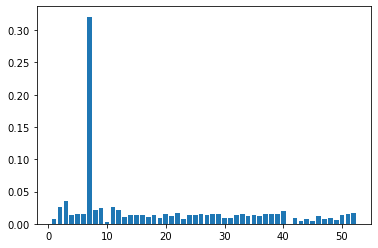

In [40]:
plt.bar(x = range(1,53), height = rand_reg.best_estimator_.feature_importances_)

In [41]:
sort_index = np.argsort(rand_reg.best_estimator_.feature_importances_)  # 오름차순 정렬
sort_index[::-1][:18] # 내림차순 정렬 후, 상위 18개 추출

array([ 6,  2,  1, 10,  8,  7, 11, 39, 51, 21, 38, 28, 37, 19,  5, 50, 27,
        4], dtype=int64)

In [42]:
temp_x = train_x.iloc[:,sort_index[::-1][:18]]
temp_val = val_x.iloc[:,sort_index[::-1][:18]]

xgb = XGBClassifier(booster = 'gbtree', max_depth = 6, objective='binary:logistic',
                    learning_rate = 0.1, n_estimators = 100, n_jobs= -1)

params = {'subsample' : [0.65, 0.7, 0.75],
         'n_estimators' : [100, 200, 300, 400, 800],
         'learning_rate' : [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
         'max_depth' : [2, 3, 5, 6, 8],
         'gamma' : [0, 0.01, 0.1, 0.5, 1, 2]
         }

rand_reg = RandomizedSearchCV(xgb,params,n_iter=10,
                              scoring='neg_mean_squared_error',
                              cv = 5, n_jobs= -1, random_state=2, verbose=1)

rand_reg.fit(temp_x,train_y)

predict = rand_reg.best_estimator_.predict(temp_val)
print(f"정확도 : {accuracy_score(predict,val_y)}")
print(f"정밀도 : {precision_score(predict,val_y)}")
print(f"재현율 : {recall_score(predict,val_y)}")
print(f"F1_Score : {f1_score(predict,val_y)}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
정확도 : 0.952465413267116
정밀도 : 0.4979253112033195
재현율 : 0.9022556390977443
F1_Score : 0.6417112299465241


In [43]:
from tqdm import tqdm
import time

for i in tqdm([1,2,3,4,5,6,7,8,9,10]):
    time.sleep(0.25)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.87it/s]
